In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer  # Still needed for ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

def load_and_examine_data(file_path):
    df = pd.read_csv(file_path)
    print("Dataset shape:", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values per column:")
    print(df.isnull().sum()[df.isnull().sum() > 0])
    print("\nFlood event distribution:")
    print(df['flood'].value_counts(normalize=True) * 100)
    return df

def remove_missing_rows(df):
    print("\nRemoving rows with missing values...")
    before = df.shape[0]
    df = df.dropna()
    after = df.shape[0]
    print(f"Removed {before - after} rows. New shape: {df.shape}")
    return df

def detect_and_handle_outliers(df, columns_to_check=None):
    if columns_to_check is None:
        columns_to_check = [col for col in ['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']
                            if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
    print("\nOutlier detection and handling:")
    for col in columns_to_check:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        print(f"{col}: {len(outliers)} outliers capped")
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

def prepare_features_and_target(df):
    numerical_features = [col for col in ['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']
                          if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

    potential_categorical = ['station_id', 'station_name', 'region_name', 'ddd_x', 'ddd_car']
    categorical_features = [col for col in potential_categorical if col in df.columns]

    target = 'flood'
    X = df[numerical_features + categorical_features]
    y = df[target]

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    if categorical_features:
        categorical_transformer = Pipeline(steps=[
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    else:
        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numerical_features)
        ])

    X_processed = preprocessor.fit_transform(X)

    if categorical_features:
        try:
            categorical_feature_names = preprocessor.transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features).tolist()
            feature_names = numerical_features + categorical_feature_names
        except:
            feature_names = numerical_features + [f'cat_{i}' for i in range(X_processed.shape[1] - len(numerical_features))]
    else:
        feature_names = numerical_features

    print(f"\nFinal preprocessed shape: {X_processed.shape}")
    print(f"Number of features: {len(feature_names)}")
    return X_processed, y, preprocessor, feature_names

def preprocess_data(file_path):
    print("Starting data preprocessing pipeline...")
    df = load_and_examine_data(file_path)
    df = remove_missing_rows(df)

    numeric_cols = [col for col in ['Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']
                    if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

    df = detect_and_handle_outliers(df, numeric_cols)

    try:
        X_processed, y, preprocessor, feature_names = prepare_features_and_target(df)
        print("Preprocessing complete!")
        return X_processed, y, df, preprocessor, feature_names
    except Exception as e:
        print(f"Error during preprocessing: {str(e)}")
        return None, None, df, None, None

if __name__ == "__main__":
    file_path = "data_finish.csv"  # Replace with your actual file path
    X_processed, y, df_processed, preprocessor, feature_names = preprocess_data(file_path)

    if X_processed is not None:
        print("Successfully preprocessed the data!")
        pd.DataFrame(X_processed, columns=feature_names).to_csv("processed_features.csv", index=False)
        df_processed.to_csv("processed_full_data.csv", index=False)
    else:
        print("Preprocessing encountered errors.")

Starting data preprocessing pipeline...


FileNotFoundError: [Errno 2] No such file or directory: 'data_finish.csv'

In [ ]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3136 entries, 1 to 5250
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          3136 non-null   object 
 1   Tn            3136 non-null   float64
 2   Tx            3136 non-null   float64
 3   Tavg          3136 non-null   float64
 4   RH_avg        3136 non-null   float64
 5   RR            3136 non-null   float64
 6   ss            3136 non-null   float64
 7   ff_x          3136 non-null   float64
 8   ddd_x         3136 non-null   float64
 9   ff_avg        3136 non-null   float64
 10  ddd_car       3136 non-null   object 
 11  station_id    3136 non-null   int64  
 12  station_name  3136 non-null   object 
 13  region_name   3136 non-null   object 
 14  flood         3136 non-null   int64  
dtypes: float64(9), int64(2), object(4)
memory usage: 392.0+ KB


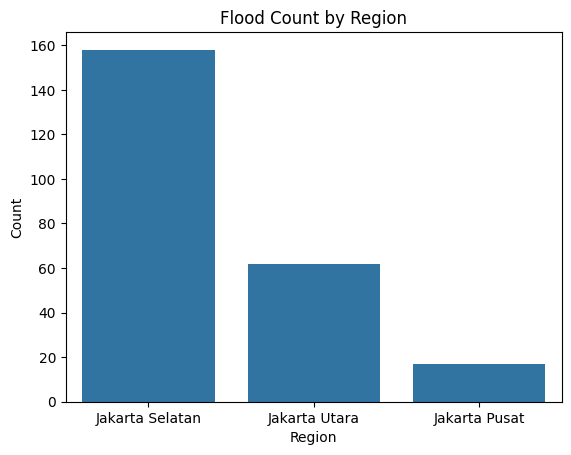

In [ ]:
sns.countplot(x='region_name', data=df_processed[df_processed['flood'] == 1])
plt.title("Flood Count by Region")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

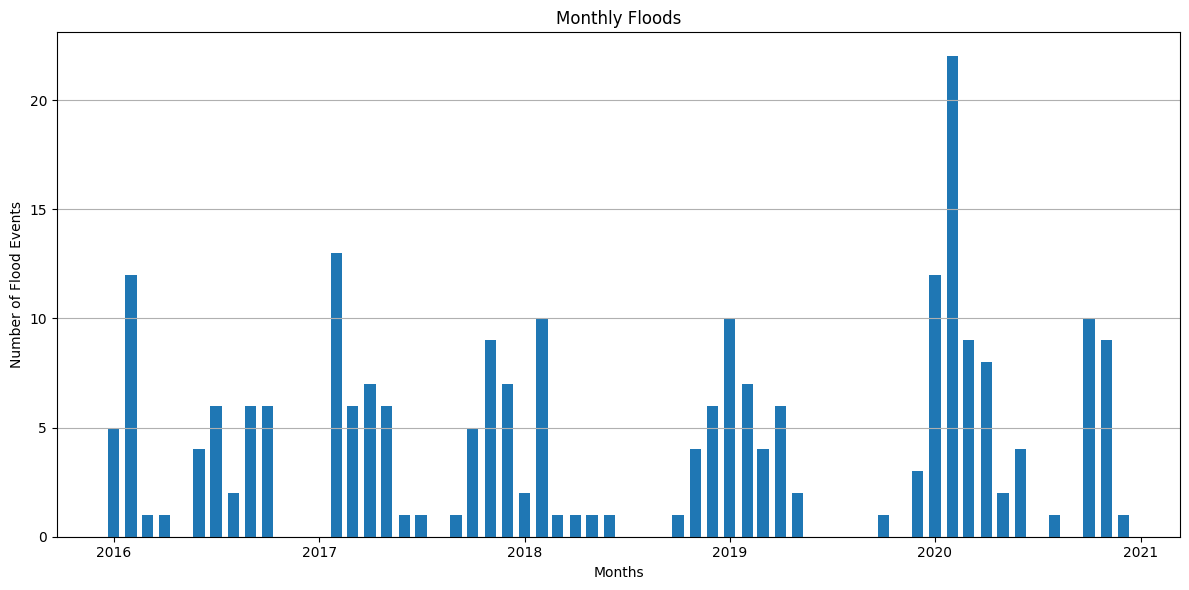

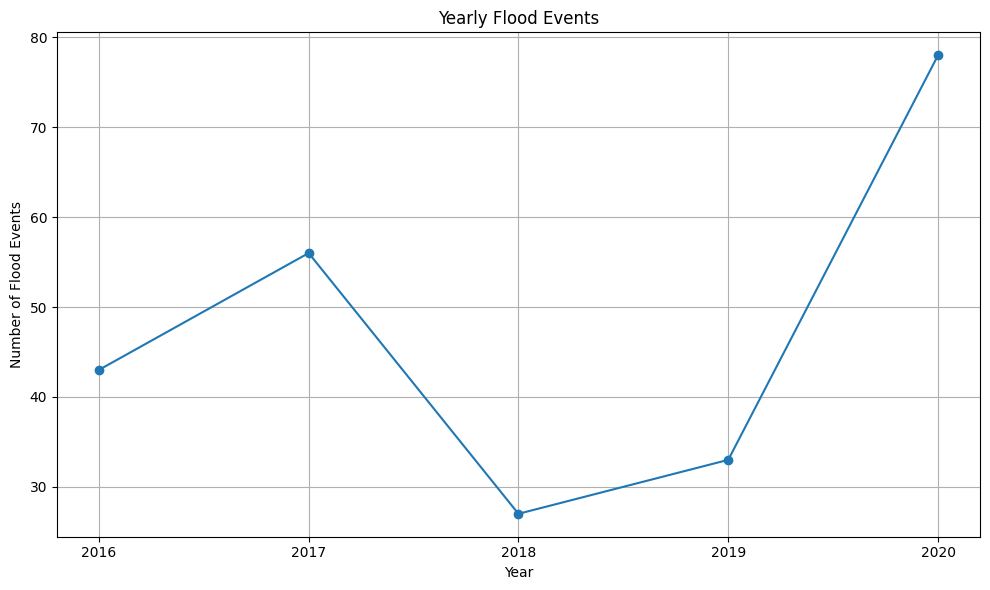

In [ ]:
df_processed['date'] = pd.to_datetime(df_processed['date'])
flood_df = df_processed[df_processed['flood'] == 1]


monthly_floods = flood_df.groupby(flood_df['date'].dt.to_period('M')).size()
monthly_floods.index = monthly_floods.index.to_timestamp()  # Convert Period to Timestamp


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(monthly_floods.index, monthly_floods.values, width=20)  # width controls bar thickness
plt.title('Monthly Floods')
plt.xlabel('Months')
plt.ylabel('Number of Flood Events')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

yearly_floods = flood_df.groupby(flood_df['date'].dt.year).size()

# Plot line chart
plt.figure(figsize=(10, 6))
plt.plot(yearly_floods.index.values, yearly_floods.values, marker='o', linestyle='-')
plt.title('Yearly Flood Events')
plt.xlabel('Year')
plt.ylabel('Number of Flood Events')
plt.xticks(yearly_floods.index.values)  # Make sure only year integers appear
plt.grid(True)
plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       581
           1       0.22      0.81      0.35        47

    accuracy                           0.77       628
   macro avg       0.60      0.79      0.60       628
weighted avg       0.92      0.77      0.82       628

Confusion Matrix:
[[447 134]
 [  9  38]]
ROC AUC Score:
0.8676163621049547


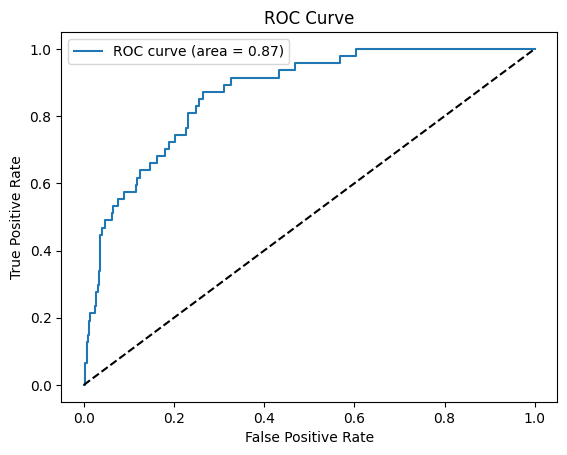

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Assuming df_processed is your DataFrame and 'flood' is the target column
X = df_processed.drop(columns=['flood', 'ddd_car', 'station_name', 'station_id', 'date', 'region_name'])  # drop non-numeric or unwanted columns
y = df_processed['flood']

# Split into train and test sets first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data only
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train logistic regression on the balanced data
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predict on the original test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:")
print(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

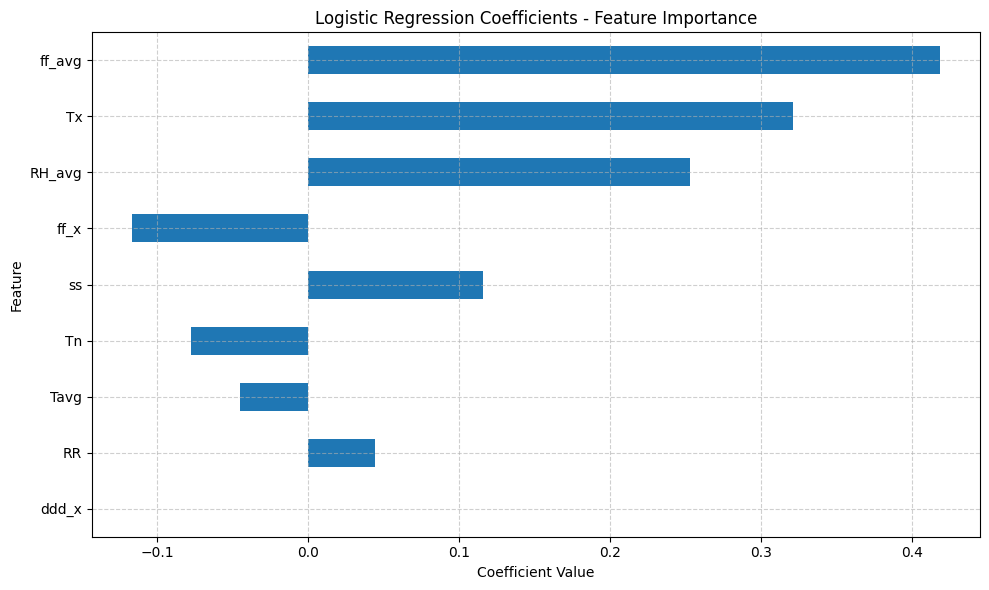

In [ ]:
coefficients = model.coef_[0]
feature_names = X.columns.tolist()

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
coef_df.set_index("Feature").Coefficient.plot(kind="barh")
plt.title("Logistic Regression Coefficients - Feature Importance")
plt.xlabel("Coefficient Value")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


# | Feature     | Interpretation                                                                                                      |
# | ----------- | ------------------------------------------------------------------------------------------------------------------- |
# | **ff\_avg** | Strongest driver for flood prediction (positive). Average wind speed — higher values increase flood risk.  |
# | **Tx**      | High max temperatures are linked to flood risk.                                                                     |
# | **RH\_avg** | High relative humidity supports flood prediction.                                                                   |
# | **ff\_x**   | (Max wind speed?) – has a **negative impact**, possibly indicating certain wind conditions reduce flood likelihood. |
# | **ss**      | Possibly sunshine duration — mild positive effect.                                                                  |
# | **Tn**      | (Min temp) — small negative influence.                                                                              |
# | **Tavg**    | Weak influence.                                                                                                     |
# | **RR**      | Surprisingly low coefficient — may be explained by multicollinearity or thresholding.                               |
# | **ddd\_x**  | (Wind direction?) — negligible impact in this model.                                                                |


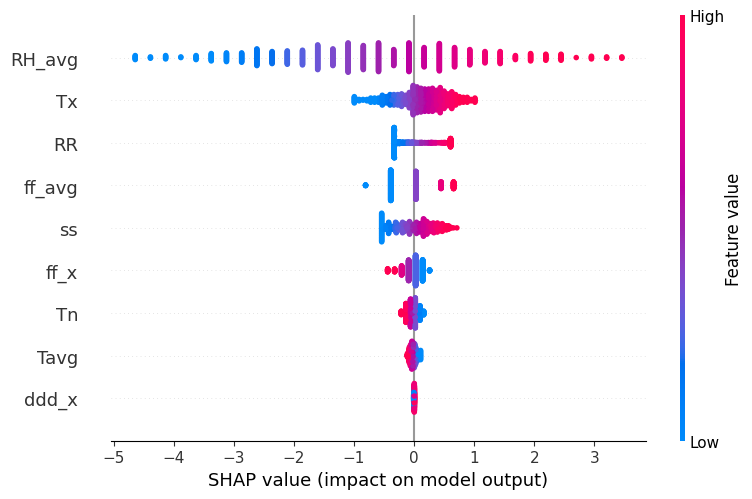

In [ ]:
import shap

explainer = shap.Explainer(model, X_train_smote)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# | Feature     | **SHAP Impact** (Model Output)                                        | **Logistic Coefficient** (Linear Importance)                        |
# | ----------- | --------------------------------------------------------------------- | ------------------------------------------------------------------- |
# | **RH\_avg** | High humidity has strong positive SHAP values → contributes to floods | Medium positive coefficient → agrees with SHAP                      |
# | **Tx**      | High values push toward flood                                         | High positive coefficient                                           |
# | **RR**      | High values push toward flood                                         | Surprisingly small coefficient → possibly suppressed by correlation |
# | **ff\_avg** | Moderate influence                                                    | **Strongest positive coefficient**                                  |
# | **ss**      | Mixed influence (moderate SHAP values)                                | Small positive coefficient                                          |
# | **ff\_x**   | Small to moderate SHAP effect                                         | **Negative coefficient** → differs from SHAP                        |
# | **Tn**      | Minimal impact                                                        | Small negative coefficient                                          |
# | **Tavg**    | Low SHAP impact                                                       | Low coefficient                                                     |
# | **ddd\_x**  | Very little SHAP effect                                               | Near-zero coefficient                                               |

# SHAP explains how and when a feature affects predictions (per instance).
# Coefficients explain direction and strength in a global linear sense.

# Using both gives a complete picture:

# Coefficients tell you what the model learned.
# SHAP tells you how the model thinks per case.



Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       580
           1       0.42      0.30      0.35        47

    accuracy                           0.92       627
   macro avg       0.68      0.63      0.65       627
weighted avg       0.91      0.92      0.91       627

Confusion Matrix:
[[561  19]
 [ 33  14]]
ROC AUC Score: 0.8188371239911959


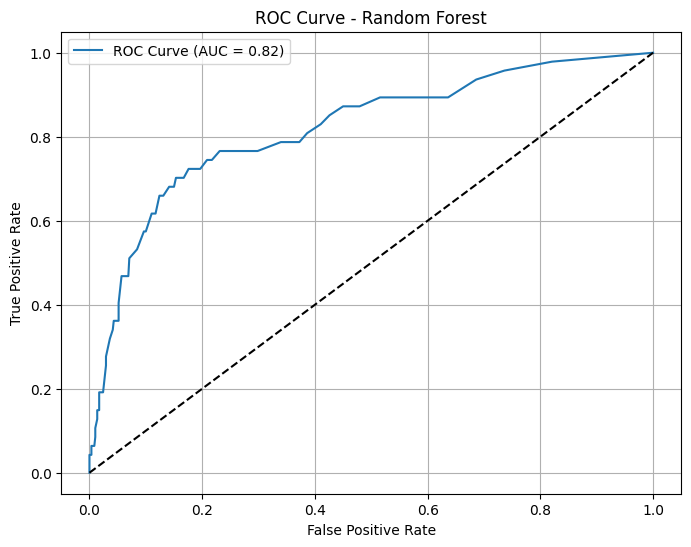

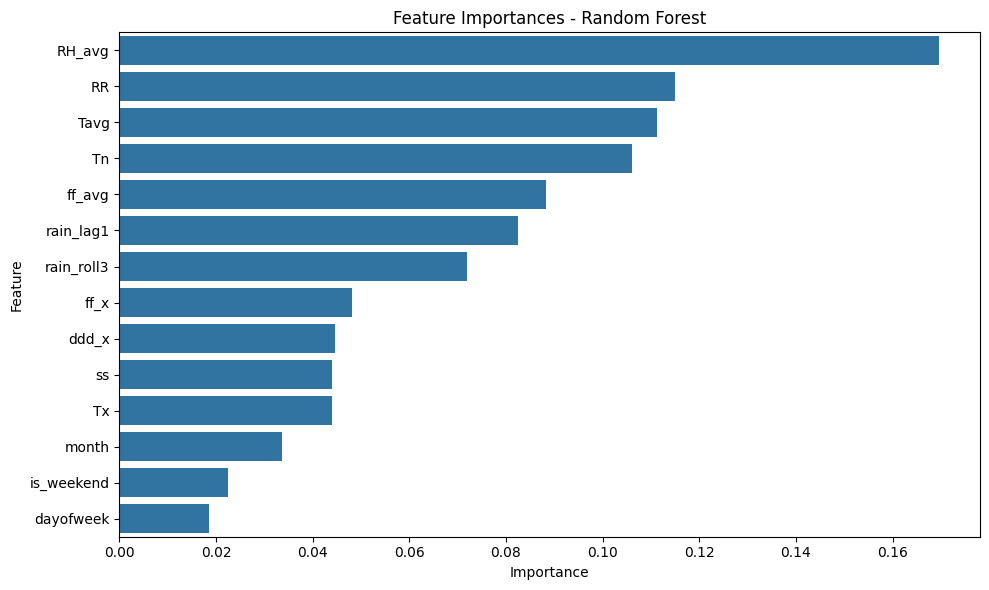

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = df_processed.drop(columns=['flood', 'ddd_car', 'station_name', 'station_id', 'date', 'region_name'])  # drop non-numeric or unwanted columns
y = df_processed['flood']

features = X.columns

# Data splitting and balancing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# Evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = %.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

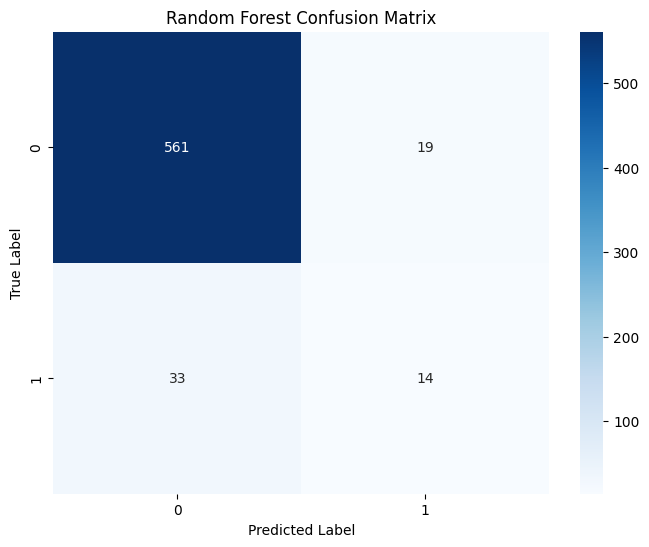

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()